In [5]:
from keras.datasets import mnist

Using TensorFlow backend.
C:\Users\uSer\AnacondaMy\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\uSer\AnacondaMy\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\uSer\AnacondaMy\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\uSer\AnacondaMy\lib\site-packages\tensorflow\python\framework\dtypes.py

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
digit = x_train[1]

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

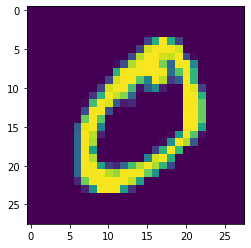

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(digit)
plt.show()

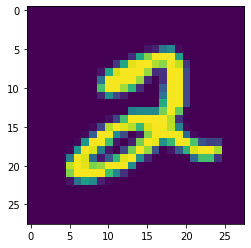

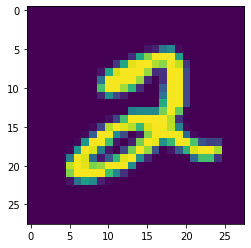

In [303]:
# превращаю матрицу цифры в вектор водов 
# n это сколько примеров берем
n = 1000
X_t = [] # новый сэт из строк-чисел
for i in range(n):
    digit = x_train[i]
    digit_row = []
    for j in range(28): # 28x28 это размер входа (числа)
        for k in range(28):
            digit_row.append(digit[j][k]/255)
    X_t.append(digit_row)

def row_to_matrix(row):
    matrix = []
    k = 0
    one_row = []
    for i in range(len(row)):
        one_row.append(row[i])
        k += 1
        if k == 28:
            k = 0
            matrix.append(one_row)
            one_row = []
    return matrix

#X_t = np.array(X_t)

fig, ax = plt.subplots()
im = ax.imshow(row_to_matrix(X_t[5]))
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(x_train[5])
plt.show()

#X_t = X_t/255


In [304]:
print(y_train[5])

Y_t = []

for i in range(n):
    ans_digit = [0,0,0,0,0,0,0,0,0,0]
    ans_digit[y_train[i]] = 1
    Y_t.append(ans_digit)

Y_t = np.array(Y_t)
print(Y_t[5].reshape((len(Y_t[5]),1)))


2
[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [289]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3
import numpy as np
import random
import time

from functools import partial
from ipywidgets import interact, RadioButtons, IntSlider, FloatSlider, Dropdown, BoundedFloatText
from numpy.linalg import norm

In [11]:
def sigmoid(x):
    """сигмоидальная функция, работает и с числами, и с векторами (поэлементно)"""
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    """производная сигмоидальной функции, работает и с числами, и с векторами (поэлементно)"""
    return sigmoid(x) * (1 - sigmoid(x))

In [12]:
def J_quadratic(neuron, X, y):
    """
    Оценивает значение квадратичной целевой функции.
    Всё как в лекции, никаких хитростей.

    neuron - нейрон, у которого есть метод vectorized_forward_pass, предсказывающий значения на выборке X
    X - матрица входных активаций (n, m)
    y - вектор правильных ответов (n, 1)
        
    Возвращает значение J (число)
    """
    
    assert y.shape[1] == 1, 'Incorrect y shape'
    
    return 0.5 * np.mean((neuron.vectorized_forward_pass(X) - y) ** 2)

def J_quadratic_derivative(y, y_hat):
    """
    Вычисляет вектор частных производных целевой функции по каждому из предсказаний.
    y_hat - вертикальный вектор предсказаний,
    y - вертикальный вектор правильных ответов,
    
    В данном случае функция смехотворно простая, но если мы захотим поэкспериментировать 
    с целевыми функциями - полезно вынести эти вычисления в отдельный этап.
    
    Возвращает вектор значений производной целевой функции для каждого примера отдельно.
    """
    
    assert y_hat.shape == y.shape and y_hat.shape[1] == 1, 'Incorrect shapes'
    
    return (y_hat - y) / len(y)


In [13]:
class Neuron:
    
    def __init__(self, weights,costF,costF_deriv,activation_function, activation_function_derivative):
        self.costF = costF
        self.costF_deriv = costF_deriv
        self.w = weights
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
    
    def summatory(self, single_input):      
        result = 0
        for i in range(len(self.w)):
            result += float(self.w[i] * single_input[i])
        return result
   

In [14]:
class Network():
    def __init__(self,layers,activeF,activeF_deriv,costF,costF_deriv,learning_rate):
        self.lay_num = len(layers)
        self.NET = []
        self.activationsL = []
        self.costF = costF
        self.costF_deriv = costF_deriv
        self.activeF = activeF
        self.activeF_deriv = activeF_deriv
        self.deltas = []
        self.summatories = []
        self.deltas = []
        self.learning_rate = learning_rate
        for L in range(self.lay_num):
            layer = []
            for j in range(layers[L]):
                if L == 0:
                    layer.append(0)
                else:
                    m = layers[L-1] # сколько у нейрона входов (столько же сколько нейронов на предыдущем слое)
                    wnp = np.random.random((m, 1))*0.1
                    w = []
                    for i in range(wnp.size):
                        w.append(wnp[i][0])
                    N = Neuron(weights = w,costF=self.costF,costF_deriv=self.costF_deriv,activation_function=self.activeF, activation_function_derivative=self.activeF_deriv)
                    layer.append(N)
            self.NET.append(layer)
            self.deltas.append([])
            self.activationsL.append([])
            self.summatories.append([])
            self.deltas.append([])
        return
    
    def predict(self,x): # x'shape is row
        for L in range(0,self.lay_num):
            if L == 0:
                a = x
                z = [0]*len(self.NET[0])
            else:
                n_L = len(self.NET[L])
                a_prev = self.activationsL[L-1]
                a = []
                z = []
                for j in range(n_L):
                    s = self.NET[L][j].summatory(a_prev)
                    z.append(s)
                    a.append(self.activeF(s))
            self.activationsL[L] = a
            self.summatories[L] = z
        return 0            
    
    def delta_Last(self,y): # y'shape is (10,1)
        aLast = self.activationsL[self.lay_num-1]
        zLast = self.summatories[self.lay_num-1]
        aLast_np = np.array(aLast).reshape((len(aLast),1))
        zLast_np = np.array(zLast).reshape((len(zLast),1))
        return self.costF_deriv(y,aLast_np)*self.activeF_deriv(zLast_np)
    
    def peekUpDeltas(self,y):                
        self.deltas[0] = np.zeros((len(self.NET[0]),1))
        self.deltas[self.lay_num-1] = self.delta_Last(y)
        for L in range(self.lay_num-2,0,-1):
            z_L = np.array(self.summatories[L]).reshape((len(self.summatories[L]),1))
            d_lp1 = self.deltas[L+1]
            u = len(self.NET[L+1])
            y = len(self.NET[L])
            w_front = np.zeros((u,y))
            for k in range(0,u):
                for j in range(0,y):
                    w_front[k][j] = self.NET[L][k].w[j].copy()
            self.deltas[L] = w_front.T.dot(d_lp1) * self.activeF_deriv(z_L)
        return 0
    
    def trainOnSingleExample(self,x,y):
        self.predict(x)
        self.peekUpDeltas(y)
        for L in range(1,self.lay_num):
            for j in range(len(self.NET[L])):
                for k in range(len(self.NET[L-1])):
                    self.NET[L][j].w[k] = self.NET[L][j].w[k] - self.activationsL[L-1][k]*self.deltas[L][j]*self.learning_rate
        return 0
        
            
        

In [18]:
# беру сериализованную обученную(new) и не обученную(old) модели
import pickle as pic

f1 = open('newNet.pkl','rb')
f2 = open('oldNet.pkl','rb')
new_model = pic.load(f1)
old_model = pic.load(f2)
f1.close()
f2.close()

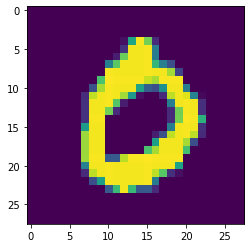

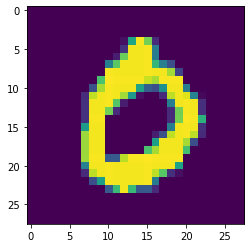

In [64]:
X_test = [] # новый сэт из строк-чисел
for i in range(n):
    digit = x_test[i]
    digit_row = []
    for j in range(28): # 28x28 это размер входа (числа)
        for k in range(28):
            digit_row.append(digit[j][k]/255)
    X_test.append(digit_row)

def row_to_matrix(row):
    matrix = []
    k = 0
    one_row = []
    for i in range(len(row)):
        one_row.append(row[i])
        k += 1
        if k == 28:
            k = 0
            matrix.append(one_row)
            one_row = []
    return matrix


fig, ax = plt.subplots()
im = ax.imshow(x_test[3])
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(row_to_matrix(X_test[3]))
plt.show()

In [65]:
new_model.predict(X_test[3])
print(new_model.activationsL[1].index(max(new_model.activationsL[1])))
print(new_model.activationsL[1])

0
[0.6417119108637154, 5.5466511005700544e-05, 0.002118778992587164, 0.0012511551034988658, 0.0002342688353363007, 0.004975616397296998, 0.0892477225142454, 0.06478203950183214, 0.0021832678125957555, 0.00037517493474662687]


In [61]:
old_model.predict(X_test[90])
print(old_model.activationsL[1].index(max(old_model.activationsL[1])))

0


In [35]:
M = np.array([[1,2,3],[2,0,1],[3,2,2]])

print(M)

N = np.linalg.pinv(M)

print(N)

print(M.dot(N))


[[1 2 3]
 [2 0 1]
 [3 2 2]]
[[-0.25   0.25   0.25 ]
 [-0.125 -0.875  0.625]
 [ 0.5    0.5   -0.5  ]]
[[ 1.00000000e+00 -4.44089210e-16  0.00000000e+00]
 [ 5.55111512e-16  1.00000000e+00 -2.22044605e-16]
 [ 5.55111512e-16 -3.33066907e-16  1.00000000e+00]]


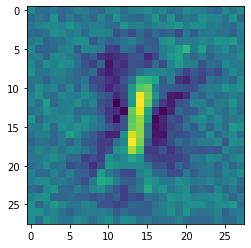

In [74]:
W = []
for j in range(len(new_model.NET[1])):
    w_L = []
    for k in range(len(new_model.NET[0])):
        w_L.append(new_model.NET[1][j].w[k][0])
    W.append(w_L)

W_revers = np.linalg.pinv(np.array(W))
one = np.array([0,1,0,0,0,0,0,0,0,0]).reshape((10,1))

digitOne = W_revers.dot(one)

def calamn_to_matrix(calamn):
    matrix = []
    k = 0
    one_row = []
    for i in range(len(calamn)):
        one_row.append(calamn[i][0])
        k += 1
        if k == 28:
            k = 0
            matrix.append(one_row)
            one_row = []
    return matrix

digitOneMatrix = calamn_to_matrix(digitOne)

fig, ax = plt.subplots()
im = ax.imshow(digitOneMatrix)
plt.show()
